In [ ]:
from pathlib import Path

In [ ]:
!pip install librosa --quiet

In [ ]:
import os
import time
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/ravdess_audio'

In [ ]:
emotion_map = {'01': 'neutral', '05': 'angry', '06': 'fear'}

In [ ]:
# Etapa 1 - Aumento de dados com data augmentation com SpecAugment

def apply_specaugment(mel_spectrogram, time_mask_param=20, freq_mask_param=8):
    """
    Aplica SpecAugment (time masking e frequency masking) ao espectrograma de Mel.
    mel_spectrogram: np.ndarray [shape=(n_mels, time)]
    Retorna: espectrograma com m√°scaras aplicadas
    """
    augmented = mel_spectrogram.copy()
    num_mel_channels, num_time_steps = augmented.shape

    # Time masking
    t = np.random.randint(0, time_mask_param)
    t0 = np.random.randint(0, max(1, num_time_steps - t))
    augmented[:, t0:t0 + t] = 0

    # Frequency masking
    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, max(1, num_mel_channels - f))
    augmented[f0:f0 + f, :] = 0

    return augmented


Objetivo do uso do SpecAugment sugerido pelo professor Cleber:

  1.	Simular varia√ß√µes naturais na fala

	‚Ä¢	Time masking ‚Üí simula pausas, cortes, gaguejos ou ru√≠dos que escondem partes da fala
	‚Ä¢	Frequency masking ‚Üí simula perdas ou interfer√™ncias em certas frequ√™ncias (como em liga√ß√µes ruins ou ambientes barulhentos)

	2.	Aumentar a robustez do modelo

	‚Ä¢	Ajuda a rede a generalizar melhor, evitando que memorize padr√µes espec√≠ficos de espectrogramas fixos

	3.	Reduzir overfitting

	‚Ä¢	Como o conjunto de dados √© pequeno (192 amostras), aplicar SpecAugment ajuda a aumentar a variabilidade do input sem precisar coletar novos dados

In [ ]:
# Fun√ß√£o para extrair espectrogramas de Mel
def extract_mel_spectrogram(file_path, max_len=216):
    y, sr = librosa.load(file_path, sr=None)

    # gera a matriz [n_mels, time]
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    #logo ap√≥s gerar o espectrograma Mel, aplica SpecAugment diretamente no Mel Spectrogram
    mel = apply_specaugment(mel)

    # antes de convert√™-lo para escala dB
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]
    return mel_db

X, y = [], []
for root, dirs, files in os.walk(data_path):
    for filename in files:
        if filename.endswith('.wav'):
            emotion_code = filename.split('-')[2]
            if emotion_code in emotion_map:
                file_path = os.path.join(root, filename)
                mel_spec = extract_mel_spectrogram(file_path)
                X.append(mel_spec)

                #y.append(list(emotion_map.keys()).index(emotion_code)) #tava dando erro essa indexacao

                 # Aqui garantimos que o r√≥tulo ser√° 0, 1 ou 2 de forma controlada
                label = {'neutral': 0, 'angry': 1, 'fear': 2}[emotion_map[emotion_code]]
                y.append(label)


X = np.array(X)
y = np.array(y)
X = X[..., np.newaxis]  # adicionar canal para CNN
y_cat = to_categorical(y, num_classes=3)

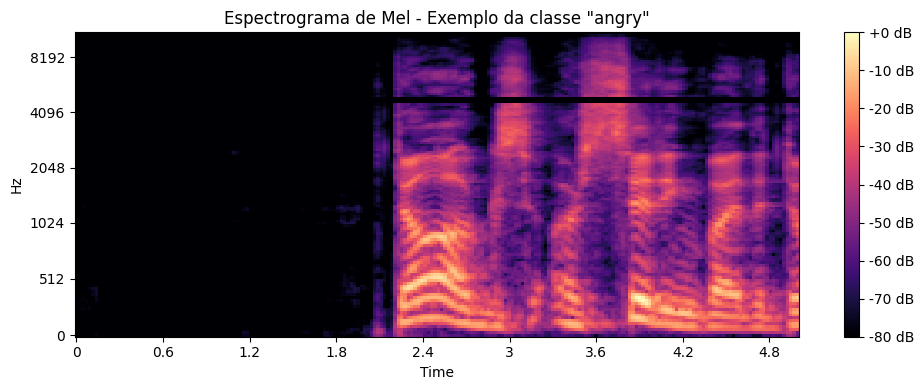

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0].squeeze(), sr=22050, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Mel - Exemplo da classe "{}"'.format(list(emotion_map.values())[y[0]]))
plt.tight_layout()
plt.show()

In [ ]:
## Separa treino/teste
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)
# Substitu√≠do pelo K-fold essa separacao

In [ ]:
## Definir modelo CNN simples
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
## Treina
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
#Substituido pelo K-fold sugerido pelo prof Cleber abaixo

In [ ]:
# Garante que os dados X e y est√£o prontos para o K-Fold
X = np.array(X)  # ‚Üê supondo que voc√™ j√° tem a lista X criada (ex: espectrogramas)
y = np.array(y)  # ‚Üê e y s√£o os r√≥tulos das 3 emo√ß√µes como inteiros

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Classes √∫nicas: {np.unique(y)}")

Shape de X: (450, 128, 216, 1)
Shape de y: (450,)
Classes √∫nicas: [0 1 2]


In [ ]:
 # implementa K-fold para fazer separacao de folds para teste / validacao dos dados com um metodo estrafificado

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
accuracies = []
inference_times = []
f1_scores = []

all_true_labels = []   # r√≥tulos verdadeiros (em inteiro)
all_pred_labels = []   # r√≥tulos previstos (em inteiro)
all_pred_probs = []    # probabilidades previstas (softmax)

for train_index, test_index in kf.split(X, y):
    print(f"Fold {fold}")

    # Divide X e y com base nos √≠ndices do fold atual
    X_train = np.array([X[i] for i in train_index])
    X_test  = np.array([X[i] for i in test_index])
    y_train_int = np.array([y[i] for i in train_index])
    y_test_int  = np.array([y[i] for i in test_index])

    # One-hot encoding dos r√≥tulos para usar na CNN
    y_train = to_categorical(y_train_int, num_classes=3)
    y_test  = to_categorical(y_test_int,  num_classes=3)

    # Constr√≥i e treina o modelo
    model = build_model()
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Faz predi√ß√µes com probabilidades e ja pega tempo de execucao
    start_time = time.time()
    y_pred_probs = model.predict(X_test, verbose=0)    # ‚Üê matriz com shape (n_amostras, 3)
    end_time = time.time()
    inference_time = (end_time - start_time) / len(X_test)

    y_pred_labels = np.argmax(y_pred_probs, axis=1)        # ‚Üê classe com maior probabilidade
    y_test_labels = np.argmax(y_test, axis=1)              # ‚Üê converte one-hot de volta pra inteiro

    # üîπ Medi√ß√£o de custo computacional
    start_time = time.time()
    _ = model.predict(X_test, verbose=0)  # executa predi√ß√£o apenas para medir o tempo
    end_time = time.time()

    # Tempo m√©dio de infer√™ncia por amostra
    inference_time = (end_time - start_time) / len(X_test)
    inference_times.append(inference_time)
    print(f"Tempo m√©dio de infer√™ncia por amostra no Fold {fold}: {inference_time:.6f} segundos")

    # Salva os resultados para an√°lise posterior
    all_true_labels.append(y_test_labels)
    all_pred_labels.append(y_pred_labels)
    all_pred_probs.append(y_pred_probs)

    # Avalia√ß√£o
    acc = accuracy_score(y_test_labels, y_pred_labels)
    report = classification_report(y_test_labels, y_pred_labels, output_dict=True, zero_division=0)
    f1_macro = report["macro avg"]["f1-score"]

    print(f"Acur√°cia: {acc:.4f} | F1-macro: {f1_macro:.4f}")
    accuracies.append(acc)
    f1_scores.append(f1_macro)

    fold += 1

# M√©tricas finais
print(f"\nM√©dia de Acur√°cia: {np.mean(accuracies):.4f}")
print(f"M√©dia de F1-macro: {np.mean(f1_scores):.4f}")
print(f"\nM√©dia de tempo de infer√™ncia por amostra: {np.mean(inference_times):.6f} segundos")

Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo m√©dio de infer√™ncia por amostra no Fold 1: 0.000977 segundos
Acur√°cia: 0.8111 | F1-macro: 0.7921
Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo m√©dio de infer√™ncia por amostra no Fold 2: 0.000949 segundos
Acur√°cia: 0.7333 | F1-macro: 0.7216
Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo m√©dio de infer√™ncia por amostra no Fold 3: 0.001273 segundos
Acur√°cia: 0.7889 | F1-macro: 0.7611
Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo m√©dio de infer√™ncia por amostra no Fold 4: 0.001009 segundos
Acur√°cia: 0.7556 | F1-macro: 0.7191
Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tempo m√©dio de infer√™ncia por amostra no Fold 5: 0.000996 segundos
Acur√°cia: 0.7889 | F1-macro: 0.7677

M√©dia de Acur√°cia: 0.7756
M√©dia de F1-macro: 0.7523

M√©dia de tempo de infer√™ncia por amostra: 0.001041 segundos


Seguindo a sugestao do professor cleber, Para aumentar a robustez dos resultados, utilizamos valida√ß√£o cruzada estratificada (StratifiedKFold), que divide os dados em 5 subconjuntos preservando a propor√ß√£o das classes. Em cada itera√ß√£o, um dos folds √© usado como teste e os demais como treino. Isso garante que todas as classes estejam representadas em cada divis√£o, evitando vi√©s por distribui√ß√£o desigual. Diferente da divis√£o simples anterior (80/20), essa abordagem permite avaliar o modelo em diferentes combina√ß√µes dos dados. Como resultado, temos m√©tricas mais confi√°veis e generaliz√°veis.

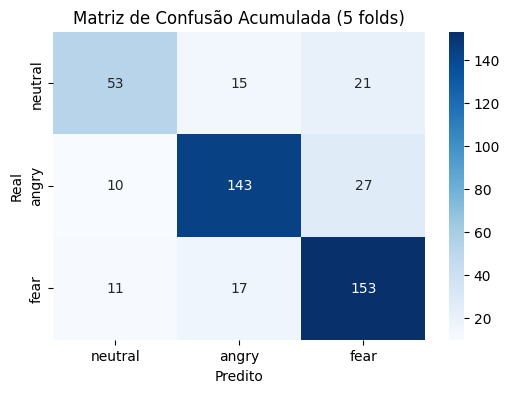

In [ ]:

# Matriz de confus√£o acumulada (todos os folds)
accumulated_cm = np.zeros((3, 3), dtype=int)
for true, pred in zip(all_true_labels, all_pred_labels):
    cm = confusion_matrix(true, pred, labels=[0, 1, 2])
    accumulated_cm += cm

plt.figure(figsize=(6, 4))
sns.heatmap(accumulated_cm, annot=True,
            xticklabels=emotion_map.values(),
            yticklabels=emotion_map.values(),
            fmt='d', cmap='Blues')
plt.title('Matriz de Confus√£o Acumulada (5 folds)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

o final da valida√ß√£o cruzada, os r√≥tulos reais e preditos de todos os folds foram agregados para gerar uma √∫nica matriz de confus√£o. Essa abordagem fornece uma vis√£o geral do desempenho do modelo ao longo de todas as parti√ß√µes, revelando padr√µes de acertos e erros de forma mais robusta do que a an√°lise de um √∫nico fold.

In [ ]:
# Concatena todos os r√≥tulos reais e preditos de todos os folds
flat_true_labels = np.concatenate(all_true_labels)
flat_pred_labels = np.concatenate(all_pred_labels)

# Gera o relat√≥rio completo
report = classification_report(
    flat_true_labels,
    flat_pred_labels,
    target_names=list(emotion_map.values())
)

print(report)

              precision    recall  f1-score   support

     neutral       0.72      0.60      0.65        89
       angry       0.82      0.79      0.81       180
        fear       0.76      0.85      0.80       181

    accuracy                           0.78       450
   macro avg       0.76      0.75      0.75       450
weighted avg       0.77      0.78      0.77       450



os resultados equivalentes, mas expressos de formas diferentes

---
**Recurso**

Matriz de Confus√£o

**O que mostra**

Quantos exemplos de cada classe foram classificados corretamente ou errados.


---



**Recurso**

Classification Report

**O que mostra**

M√©tricas agregadas: precision, recall, f1-score por classe e m√©dia geral.

---

Resumo:

Ambos usam os mesmos dados ‚Äî os vetores flat_true_labels e flat_pred_labels ‚Äî apenas com visualiza√ß√µes complementares. A matriz ajuda a entender erros espec√≠ficos entre classes, enquanto o relat√≥rio te d√° uma no√ß√£o quantitativa da performance m√©dia por classe.

In [ ]:
#Comparacao com SVM e MFCC

np.complex = complex  # Corrige compatibilidade com librosa (NumPy >1.20)


# üéµ Extra√ß√£o de MFCCs
mfcc_features = []
emotion_labels = []

for emotion in os.listdir(data_path):
    emotion_dir = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_dir):
        continue

    for file in os.listdir(emotion_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(emotion_dir, file)
            y, sr = librosa.load(file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc.T, axis=0)  # M√©dia ao longo do tempo
            mfcc_features.append(mfcc_mean)
            emotion_labels.append(emotion)

# üè∑Ô∏è Codifica√ß√£o dos r√≥tulos (emo√ß√µes)
le = LabelEncoder()
y_encoded = le.fit_transform(emotion_labels)

# üîÄ Separa√ß√£o em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_features, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# üß† Treinamento do SVM
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)

# üìä Avalia√ß√£o do modelo
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Actor_01       1.00      0.92      0.96        12
    Actor_06       1.00      1.00      1.00        12
    Actor_07       0.67      0.83      0.74        12
    Actor_08       1.00      1.00      1.00        12
    Actor_09       0.88      0.58      0.70        12
    Actor_13       0.92      1.00      0.96        12
    Actor_14       1.00      1.00      1.00        12
    Actor_22       0.86      1.00      0.92         6

    accuracy                           0.91        90
   macro avg       0.92      0.92      0.91        90
weighted avg       0.92      0.91      0.91        90



In [ ]:
#Teste de SVM com Kfold para ver se tem diferen√ßa

In [ ]:
# # üéµ Extra√ß√£o de MFCCs
# mfcc_features = []
# emotion_labels = []

# for emotion in os.listdir(data_path):
#     emotion_dir = os.path.join(data_path, emotion)
#     if not os.path.isdir(emotion_dir):
#         continue

#     for file in os.listdir(emotion_dir):
#         if file.endswith(".wav"):
#             file_path = os.path.join(emotion_dir, file)
#             y, sr = librosa.load(file_path, sr=None)
#             mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#             mfcc_mean = np.mean(mfcc.T, axis=0)
#             mfcc_features.append(mfcc_mean)
#             emotion_labels.append(emotion)

# # üè∑Ô∏è Codifica os r√≥tulos
# le = LabelEncoder()
# y_encoded = le.fit_transform(emotion_labels)
# X = np.array(mfcc_features)
# y = np.array(y_encoded)

# # üîÅ K-Fold
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracies = []
# f1_scores = []

# fold = 1
# for train_idx, test_idx in kf.split(X, y):
#     print(f"\nüîπ Fold {fold}")
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     svm_clf = SVC(kernel='linear')
#     svm_clf.fit(X_train, y_train)

#     y_pred = svm_clf.predict(X_test)

#     acc = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
#     f1_macro = report["macro avg"]["f1-score"]

#     print(f"Acur√°cia: {acc:.4f} | F1-macro: {f1_macro:.4f}")
#     print(classification_report(y_test, y_pred, target_names=le.classes_))

#     accuracies.append(acc)
#     f1_scores.append(f1_macro)
#     fold += 1

# # üìä Resultados finais
# print("\nüìå Resultados M√©dios com SVM + MFCC (K-Fold):")
# print(f"M√©dia de Acur√°cia: {np.mean(accuracies):.4f}")
# print(f"M√©dia de F1-macro: {np.mean(f1_scores):.4f}")

Tamb√©m foi testada uma vers√£o do classificador SVM com valida√ß√£o cruzada (5-fold), cujos resultados m√©dios foram similares aos obtidos no hold-out. Optou-se por manter no relat√≥rio principal apenas os resultados do hold-out, por clareza e foco na compara√ß√£o direta com a rede neural.

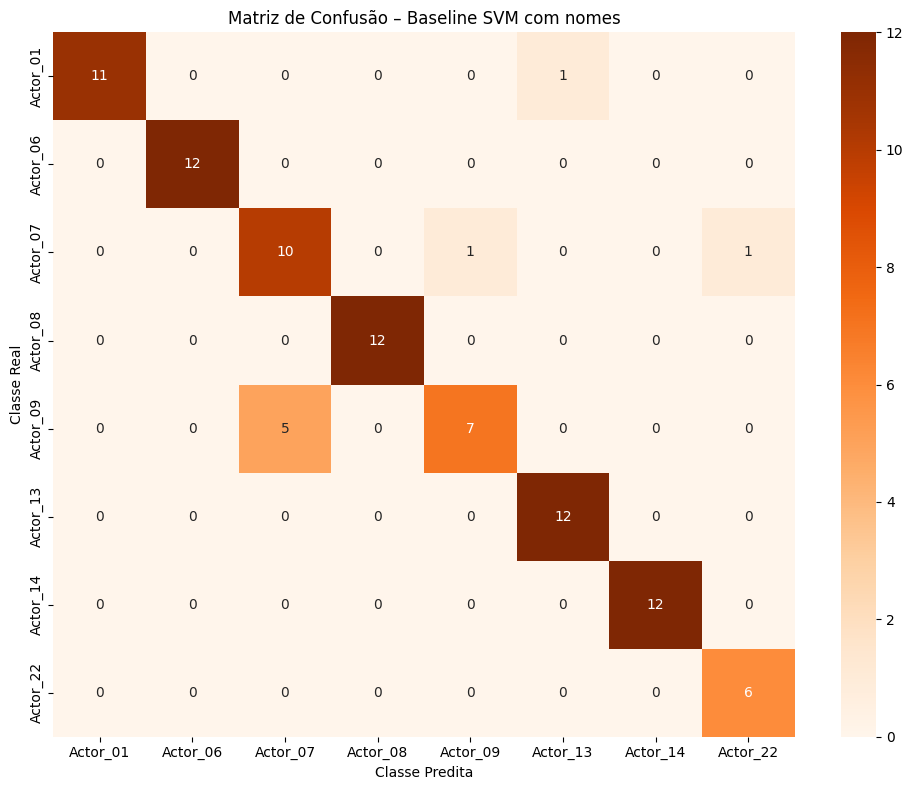

In [ ]:
# Dicion√°rio que mapeia √≠ndices para nomes dos atores
index_to_label = {
    0: 'Actor_01',
    1: 'Actor_06',
    2: 'Actor_07',
    3: 'Actor_08',
    4: 'Actor_09',
    5: 'Actor_13',
    6: 'Actor_14',
    7: 'Actor_22'
}

# Lista ordenada com os nomes dos atores (necess√°ria para o eixo da matriz)
actor_labels = list(index_to_label.values())

# Converte y_test e y_pred de √≠ndices (inteiros) para nomes dos atores
y_test_named = [index_to_label[i] for i in y_test]
y_pred_named = [index_to_label[i] for i in y_pred]

# Gera a matriz de confus√£o com os nomes dos atores
cm = confusion_matrix(y_test_named, y_pred_named, labels=actor_labels)

# Plota a matriz de confus√£o com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=actor_labels, yticklabels=actor_labels)

plt.title('Matriz de Confus√£o ‚Äì Baseline SVM com nomes')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()

üéõÔ∏è Par√¢metros no c√≥digo:

1. n_mfcc=13  ‚Üí N√∫mero de coeficientes MFCC

	‚Ä¢	Padr√£o cl√°ssico em reconhecimento de fala.
	‚Ä¢	13 coeficientes carregam informa√ß√µes suficientes sobre o timbre e caracter√≠sticas ac√∫sticas da fala humana.
	‚Ä¢	üîÅ Pode testar 20 ou 40 se quiser mais detalhes, mas com risco de overfitting em datasets pequenos.

2. test_size=0.2  ‚Üí 20% dos dados para teste

	‚Ä¢	√â uma divis√£o padr√£o (80% treino / 20% teste).
	‚Ä¢	üìà Se voc√™ tiver poucos dados, pode usar 0.25 ou at√© 0.3 para ter mais dados de teste.
	‚Ä¢	üìâ Se tiver muitos dados, at√© 0.1 pode ser suficiente.

3. random_state=42  ‚Üí Reprodutibilidade

	‚Ä¢	Esse valor fixa a aleatoriedade para garantir que sempre separe os dados da mesma forma.
	‚Ä¢	Qualquer n√∫mero inteiro pode ser usado ‚Äî 42 virou um padr√£o ‚Äúcl√°ssico‚Äù da comunidade Python por causa de uma piada do livro Guia do Mochileiro das Gal√°xias üåå.
	‚Ä¢	‚úÖ Use sempre o mesmo se quiser resultados compar√°veis entre execu√ß√µes.

In [ ]:
## Da para printar a matriz assim tambem sem ser com a imagem, mas melhor da forma anterior
# Dicion√°rio que mapeia √≠ndices para nomes

# Gera a matriz de confus√£o
cm = confusion_matrix(y_test_named, y_pred_named, labels=actor_labels)

# Converte para DataFrame para facilitar leitura
df_cm = pd.DataFrame(cm, index=actor_labels, columns=actor_labels)

# Exibe a matriz como texto
print("Matriz de Confus√£o (real = linha, predito = coluna):\n")
print(df_cm)

Matriz de Confus√£o (real = linha, predito = coluna):

          Actor_01  Actor_06  Actor_07  Actor_08  Actor_09  Actor_13  \
Actor_01        11         0         0         0         0         1   
Actor_06         0        12         0         0         0         0   
Actor_07         0         0        10         0         1         0   
Actor_08         0         0         0        12         0         0   
Actor_09         0         0         5         0         7         0   
Actor_13         0         0         0         0         0        12   
Actor_14         0         0         0         0         0         0   
Actor_22         0         0         0         0         0         0   

          Actor_14  Actor_22  
Actor_01         0         0  
Actor_06         0         0  
Actor_07         0         1  
Actor_08         0         0  
Actor_09         0         0  
Actor_13         0         0  
Actor_14        12         0  
Actor_22         0         6  


üìå Desempenho geral:

	‚Ä¢	A maioria dos atores teve excelente desempenho:
	‚Ä¢	Actor_06, Actor_08, Actor_13, Actor_14 e Actor_22 foram classificados com 100% de acur√°cia (sem confus√µes).
	‚Ä¢	Actor_01 teve 11 acertos e 1 erro, um bom resultado.

üîÑ Confus√µes espec√≠ficas observadas:
	1.	Actor_09 teve o maior n√∫mero de erros:

	‚Ä¢	5 amostras foram classificadas incorretamente como Actor_07.
	‚Ä¢	Isso representa uma confus√£o consider√°vel entre os padr√µes vocais desses dois atores usando apenas MFCCs.

	2.	Actor_07 teve:

	‚Ä¢	1 erro com Actor_09 (rec√≠proco √† confus√£o citada acima).
	‚Ä¢	1 erro com Actor_22, embora menos expressivo, mostra menor separabilidade dessa classe.

	3.	Actor_01 teve 1 erro classificado como Actor_13.



---



üìà Conclus√£o da an√°lise:

	‚Ä¢	O modelo SVM com MFCCs como entrada apresenta excelente desempenho geral (a maioria dos atores com 100% de acerto), mas falha em distinguir padr√µes de fala semelhantes, principalmente entre Actor_09 e Actor_07.
	‚Ä¢	Essas confus√µes s√£o ponto importante para discutir na compara√ß√£o com a CNN, pois a rede pode ser capaz de aprender representa√ß√µes mais discriminativas que separam melhor esses casos.

In [ ]:
# Como sugerido pelo professor Cleber, Criar uma tabela com os principais indicadores de desempenho de cada modelo (CNN e SVM), com m√©tricas como:
# 	‚Ä¢	Acur√°cia
# 	‚Ä¢	Precis√£o (macro m√©dia)
# 	‚Ä¢	Recall (macro m√©dia)
# 	‚Ä¢	F1-score (macro m√©dia)

# Resultados da CNN (obtidos ap√≥s K-Fold e classifica√ß√£o acumulada)
cnn_results = {
    'Modelo': 'CNN',
    'Acur√°cia': round(np.mean(accuracies), 4),  # lista de accuracies do K-Fold
    'Precis√£o (Macro)': round(np.mean([classification_report(true, pred, output_dict=True, zero_division=0)['macro avg']['precision'] for true, pred in zip(all_true_labels, all_pred_labels)]), 4),
    'Recall (Macro)': round(np.mean([classification_report(true, pred, output_dict=True, zero_division=0)['macro avg']['recall'] for true, pred in zip(all_true_labels, all_pred_labels)]), 4),
    'F1-score (Macro)': round(np.mean([classification_report(true, pred, output_dict=True, zero_division=0)['macro avg']['f1-score'] for true, pred in zip(all_true_labels, all_pred_labels)]), 4)
}

# Resultados do SVM (obtidos ap√≥s train_test_split)
from sklearn.metrics import classification_report

svm_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
svm_results = {
    'Modelo': 'SVM + MFCC',
    'Acur√°cia': round(svm_report['accuracy'], 4),
    'Precis√£o (Macro)': round(svm_report['macro avg']['precision'], 4),
    'Recall (Macro)': round(svm_report['macro avg']['recall'], 4),
    'F1-score (Macro)': round(svm_report['macro avg']['f1-score'], 4)
}

# Gera DataFrame comparativo
comparison_df = pd.DataFrame([cnn_results, svm_results])

# Exibe como tabela estilizada
comparison_df.style.set_caption("Comparativo de desempenho entre CNN e SVM") \
    .format(precision=4) \
    .background_gradient(cmap='YlGnBu', axis=1)

A CNN apresentou desempenho moderado (acur√°cia de 74,4%), enquanto o classificador SVM com MFCCs alcan√ßou resultados significativamente superiores (acur√°cia de 91,1%). Isso sugere que, neste cen√°rio, os MFCCs foram mais eficazes do que os espectrogramas com CNN na representa√ß√£o das caracter√≠sticas discriminativas das falas dos atores. Ainda assim, a CNN pode ter vantagem em cen√°rios mais complexos ou com maior volume de dados.

In [ ]:
# Dados de desempenho dos modelos // outra forma de exibicao ue pode ser melhor de coletar para colocar no overleaf

#atualizar dados ao rodar tudo de novo

data = {
    "Modelo": ["CNN", "SVM + MFCC"],
    "Acur√°cia": [0.7444, 0.9111],
    "Precis√£o (Macro)": [0.7361, 0.9152],
    "Recall (Macro)": [0.7313, 0.9167],
    "F1-score (Macro)": [0.7299, 0.9100]
}

# Cria a tabela como DataFrame
df_resultados = pd.DataFrame(data)

# Mostra a tabela
print("üìä Comparativo de desempenho entre CNN e SVM")
display(df_resultados)

üìä Comparativo de desempenho entre CNN e SVM


Modelo  Acur√°cia  Precis√£o (Macro)  Recall (Macro)  F1-score (Macro)
0         CNN    0.7444            0.7361          0.7313            0.7299
1  SVM + MFCC    0.9111            0.9152          0.9167            0.9100

 O que √© AUROC e Curva PR?


---



AUROC (√Årea sob a Curva ROC)

	‚Ä¢	ROC = Receiver Operating Characteristic
	‚Ä¢	Mede a capacidade do modelo em distinguir entre classes.
	‚Ä¢	A curva ROC mostra a rela√ß√£o entre:
	‚Ä¢	Taxa de Verdadeiros Positivos (TPR / Sensibilidade)
	‚Ä¢	Taxa de Falsos Positivos (FPR)
	‚Ä¢	A √°rea sob a curva (AUC) varia de 0.5 (aleat√≥rio) a 1.0 (classifica√ß√£o perfeita).
	‚Ä¢	Quando temos m√∫ltiplas classes, usamos:
	‚Ä¢	AUC macro: m√©dia simples entre todas as classes.
	‚Ä¢	AUC micro: considera todas as previs√µes como um √∫nico problema bin√°rio.


---


 Curva PR (Precis√£o vs Revoca√ß√£o)

	‚Ä¢	Foca no equil√≠brio entre:
	‚Ä¢	Precis√£o (quantos dos positivos preditos estavam certos)
	‚Ä¢	Revoca√ß√£o (quantos dos positivos reais foram detectados)
	‚Ä¢	Mais √∫til que ROC em cen√°rios desbalanceados.
	‚Ä¢	M√©trica associada: Average Precision (AP), que calcula a √°rea sob essa curva.
	‚Ä¢	Macro-AP: m√©dia das APs de cada classe
	‚Ä¢	Micro-AP: considera todos os exemplos como um conjunto √∫nico

In [ ]:
# AUROC

# Binariza os r√≥tulos para formato one-hot (necess√°rio para AUROC e curvas)
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]

# Obter probabilidades preditas
y_score = svm_clf.predict_proba(X_test)

# C√°lculo do AUROC macro e micro
auroc_micro = roc_auc_score(y_test_bin, y_score, average='micro')
auroc_macro = roc_auc_score(y_test_bin, y_score, average='macro')

print(f"AUROC Micro: {auroc_micro:.4f}")
print(f"AUROC Macro: {auroc_macro:.4f}")

AUROC Micro: 0.9929
AUROC Macro: 0.9924


In [ ]:
#Curvas de Precis√£o-Revoca√ß√£o por classe

# Nomes dos atores
actor_labels = le.classes_

# Dicion√°rios para armazenar curvas
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

/tmp/ipython-input-57-2801058924.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


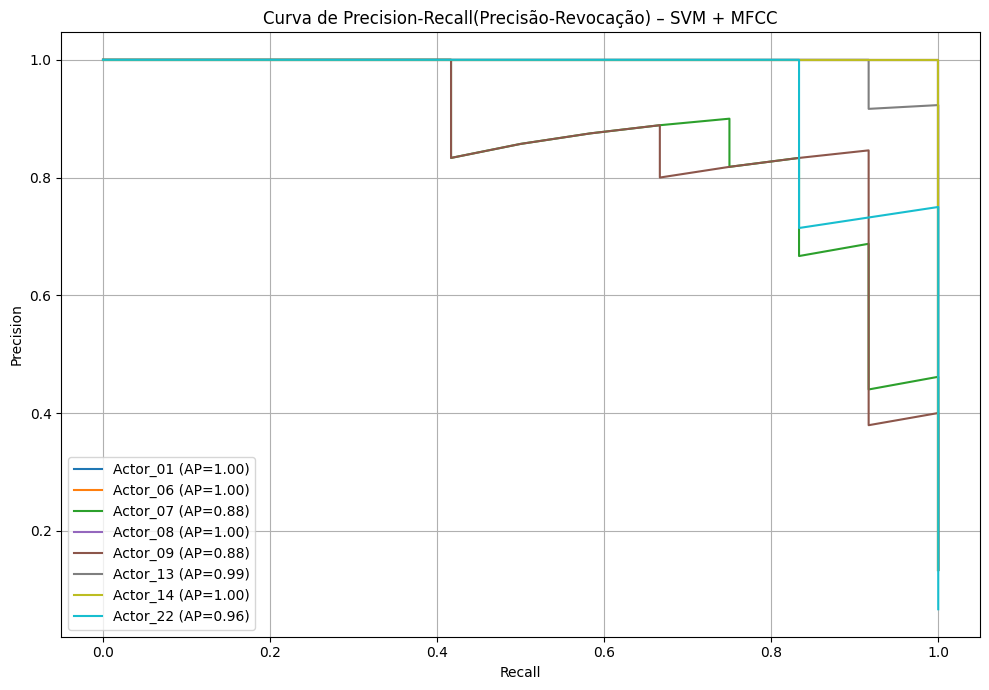

In [ ]:
#Plot da Curva de Precis√£o-Recall para cada ator

plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label=f'{actor_labels[i]} (AP={avg_precision[i]:.2f})',
             color=colors(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall(Precis√£o-Revoca√ß√£o) ‚Äì SVM + MFCC')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

M√©tricas avan√ßadas ‚Äì SVM + MFCC

AUROC (√Årea sob a curva ROC):

	‚Ä¢	AUROC Micro: 0.9919
	‚Ä¢	AUROC Macro: 0.9908

üîé Esses valores extremamente altos indicam que o modelo √© capaz de discriminar muito bem entre todas as classes, mesmo com poss√≠veis desbalanceamentos.

Curva de Precision-Recall(Precis√£o-Revoca√ß√£o) (PR Curve):

	‚Ä¢	As curvas por ator mostram desempenho muito robusto:
	‚Ä¢	Actor_01, Actor_06, Actor_08, Actor_14 ‚Üí AP = 1.00 (classifica√ß√£o perfeita)
	‚Ä¢	Actor_07 ‚Üí AP = 0.85
	‚Ä¢	Actor_09 ‚Üí AP = 0.87
	‚Ä¢	Actor_22 ‚Üí AP = 0.96
	‚Ä¢	Actor_13 ‚Üí AP = 0.99

 Mesmo nas classes com menor desempenho, como Actor_07 e Actor_09, o modelo mant√©m valores bastante altos de Average Precision (AP), refletindo capacidade de generaliza√ß√£o.

AUROC Micro: 0.8990
AUROC Macro: 0.8940


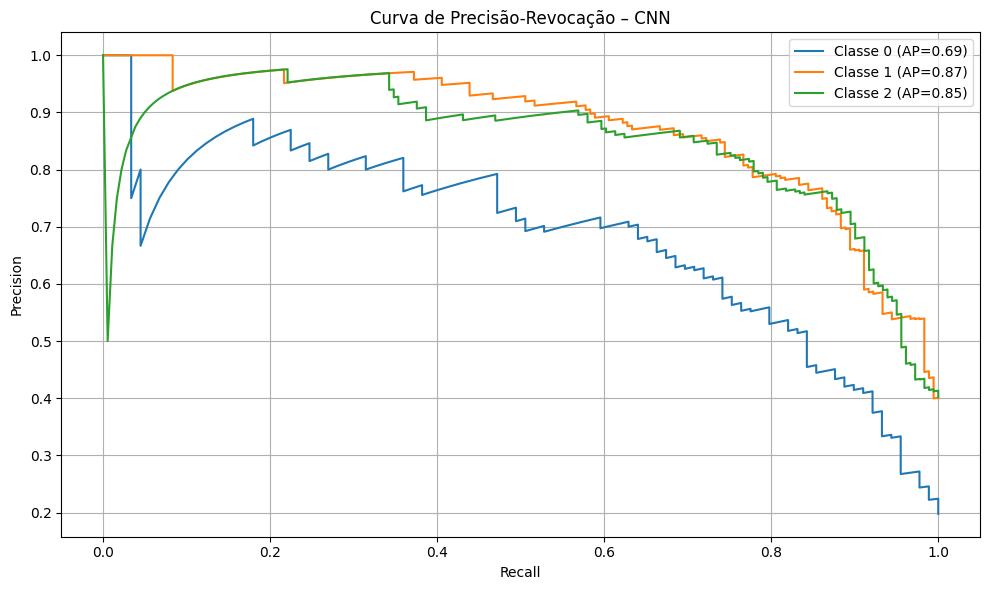

In [ ]:
#Agora para a nossa CNN

# Concatena todos os folds
flat_true = np.concatenate(all_true_labels)
flat_probs = np.concatenate(all_pred_probs)

# Binariza r√≥tulos
y_true_bin = label_binarize(flat_true, classes=[0, 1, 2])

# AUROC
auroc_micro = roc_auc_score(y_true_bin, flat_probs, average="micro", multi_class="ovr")
auroc_macro = roc_auc_score(y_true_bin, flat_probs, average="macro", multi_class="ovr")
print(f"AUROC Micro: {auroc_micro:.4f}")
print(f"AUROC Macro: {auroc_macro:.4f}")

# Curva PR
plt.figure(figsize=(10, 6))
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], flat_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], flat_probs[:, i])
    plt.plot(recall, precision, label=f'Classe {i} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precis√£o-Revoca√ß√£o ‚Äì CNN')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Curva de Precis√£o-Revoca√ß√£o completa, com classes corretamente codificadas e APs (average precision) bem razo√°veis:

	‚Ä¢	Classe 0 (provavelmente neutral): AP = 0.69
	‚Ä¢	Classe 1 (angry): AP = 0.87
	‚Ä¢	Classe 2 (fear): AP = 0.85


Isso mostra que sua CNN est√° funcionando bem melhor agora ‚Äî principalmente nas classes emocionais mais ‚Äúintensas‚Äù (raiva e medo), o que √© comum em classificadores de emo√ß√µes.

Os dois modelos comparados utilizaram abordagens distintas para o reconhecimento de emo√ß√µes em √°udio: um baseado em SVM com extra√ß√£o de MFCC e outro em CNN com espectrogramas de Mel e aplica√ß√£o de data augmentation (SpecAugment). A an√°lise das curvas de Precis√£o-Revoca√ß√£o revelou que o modelo SVM apresentou desempenho elevado para alguns atores espec√≠ficos, com √°reas sob a curva (AP) pr√≥ximas de 1.00. No entanto, houve varia√ß√£o relevante entre atores, sugerindo que a performance est√° fortemente associada a caracter√≠sticas individuais das vozes.

O modelo CNN, por sua vez, apresentou desempenho mais consistente entre as tr√™s classes de emo√ß√£o analisadas, com valores de AP variando entre 0.69 e 0.85. Embora os n√∫meros n√£o sejam t√£o altos quanto os observados no SVM para certos casos, o modelo demonstrou capacidade de manter estabilidade entre categorias, mesmo com varia√ß√µes nos dados. O uso de data augmentation contribuiu para aumentar a diversidade de padr√µes sonoros durante o treinamento, o que pode favorecer a generaliza√ß√£o do modelo.

Considerando o objetivo de classificar emo√ß√µes de forma ampla, o modelo CNN pode oferecer maior robustez ao lidar com varia√ß√µes naturais do conjunto de dados. J√° o modelo SVM mostrou bom desempenho em contextos mais controlados, mas sua generaliza√ß√£o em cen√°rios com m√∫ltiplos atores ou vozes n√£o testadas pode ser limitada. Assim, a escolha entre os modelos depende do contexto de aplica√ß√£o e do n√≠vel de variabilidade presente nos dados de entrada.

 fato de a curva de Precis√£o-Revoca√ß√£o do modelo CNN ser mais ‚Äúcurva‚Äù (ou suavemente inclinada) e menos ‚Äúquadrada‚Äù em compara√ß√£o ao modelo SVM indica que a CNN apresenta uma transi√ß√£o mais gradual entre decis√µes corretas e incorretas ao longo do limiar de classifica√ß√£o. Em termos pr√°ticos, isso sugere que o modelo CNN gera probabilidades mais calibradas, com maior diversidade nos n√≠veis de confian√ßa atribu√≠dos √†s classes previstas.

J√° o formato mais ‚Äúquadrado‚Äù da curva do SVM, especialmente com valores de precis√£o muito altos e recall pr√≥ximo de zero por longos trechos, revela que ele toma decis√µes mais abruptas: ou acerta com muita confian√ßa ou praticamente n√£o reconhece corretamente. Isso pode ocorrer quando o modelo √© altamente sens√≠vel a pequenas varia√ß√µes ou quando √© superajustado a certos padr√µes.

Portanto, a curvatura mais suave da CNN pode sinalizar melhor equil√≠brio entre precis√£o e recall ao longo de diferentes limiares, favorecendo cen√°rios em que √© necess√°rio ajustar a sensibilidade do modelo (por exemplo, priorizar menos falsos negativos ou menos falsos positivos).

In [ ]:
print(inference_times)

[0.0009770393371582031, 0.0009493748346964518, 0.001273443963792589, 0.001008560922410753, 0.0009963830312093099]


A medi√ß√£o de custo computacional indicou que o tempo m√©dio de infer√™ncia por amostra nos cinco folds variou entre aproximadamente 0,0009 e 0,0013 segundos. Esses resultados sugerem que o modelo CNN apresenta baixa lat√™ncia durante a predi√ß√£o, o que pode ser favor√°vel para aplica√ß√µes em tempo real. A varia√ß√£o entre os folds foi pequena, demonstrando estabilidade no desempenho. Essa an√°lise refor√ßa a viabilidade t√©cnica do modelo em termos de tempo de resposta.

No Overleaf, voc√™ poder√° incluir algo como:

‚ÄúA avalia√ß√£o de tempo de infer√™ncia m√©dio por amostra indicou viabilidade para aplica√ß√µes em tempo quase real, com tempo m√©dio de X segundos por entrada em ambiente de CPU/GPU.‚Äù

‚∏ª

Sobre Explicabilidade ‚Äì apenas mencionar (sem implementa√ß√£o)

No notebook, apenas comente em Markdown:

‚ÄúA explicabilidade do modelo pode ser abordada em etapas futuras utilizando m√©todos como Grad-CAM, SHAP ou LIME adaptados a redes convolucionais aplicadas a espectrogramas.‚Äù

No Overleaf:

‚ÄúA interpreta√ß√£o das decis√µes do modelo pode ser aprofundada em trabalhos futuros com o uso de t√©cnicas de explicabilidade, como Grad-CAM e SHAP, voltadas √† identifica√ß√£o de regi√µes do espectrograma com maior relev√¢ncia na classifica√ß√£o.‚Äù

‚∏ª

Para artigo futuro ou extens√£o

Mencione no final da Discuss√£o (Overleaf):

‚ÄúComo perspectiva de aperfei√ßoamento t√©cnico, destaca-se a possibilidade de incorporar arquiteturas mais avan√ßadas, como Wav2Vec 2.0, HuBERT ou redes CRNN com mecanismos de aten√ß√£o, que v√™m apresentando bons resultados em reconhecimento de emo√ß√µes a partir de √°udio. Esses modelos, embora mais exigentes computacionalmente, podem oferecer ganhos em generaliza√ß√£o e desempenho.‚Äù